In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [3]:
mice_eeg1 = pd.read_csv('pw3_data/EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('pw3_data/EEG_mouse_data_2.csv')
mice_eeg = pd.concat([mice_eeg1, mice_eeg2], ignore_index=True)

mice_test = pd.read_csv("pw3_data/EEG_mouse_data_test.csv")

In [4]:
# Dataset avec les 25 valeurs + 1 pour les états
data = mice_eeg.iloc[:,:26]

In [5]:
# Instanciez un objet StandardScaler
scaler = StandardScaler()

# Normalisez les données
mice25features_input = scaler.fit_transform(data.iloc[:,1:])

In [6]:
# Preparation donnée
# On sépare les valeurs du resultat pour pouvoir utiliser dans le K-fold
mice25features_output = data['state']

# Remplacement des valeurs car le model n'aime pas les char
mice25features_output = mice25features_output.replace('w',1).replace('n',-1).replace('r',-1)

In [7]:
import keras
from keras import layers
from sklearn.model_selection import KFold

#Création des 3 folds
keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)

# On affiche juste les folds
for i, (train_index, test_index) in enumerate(kf.split(mice25features_input)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")


2024-04-17 13:00:37.987933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 0:
  Train: index=[    0     2     3 ... 40860 40861 40862]
  Test:  index=[    1     8    15 ... 40854 40856 40857]
Fold 1:
  Train: index=[    0     1     4 ... 40859 40860 40862]
  Test:  index=[    2     3     5 ... 40855 40858 40861]
Fold 2:
  Train: index=[    1     2     3 ... 40857 40858 40861]
  Test:  index=[    0     4     6 ... 40859 40860 40862]


In [8]:
#Création du model
def create_model():
  mlp = keras.Sequential([
      layers.Input(25),
      layers.Dense(32, activation="tanh"), # Try different numbers of hidden neurons here (e.g. 2, 4, 8, 32, 128)
      layers.Dense(1, activation="tanh"),
  ])

  # Experiment with hyperparameters here:
  # momentum: [0, 0.8, 0.9, 0.99]
  # learning_rate: [0.1, 0.01, 0.001, 0.0001]
  mlp.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.99),
      loss="mse",
  )

  return mlp

mlp = create_model()
print(mlp.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                832       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________
None


2024-04-17 13:00:40.834881: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
history_list = []
trained_mlp = []

for i, (train_index, test_index) in enumerate(kf.split(mice25features_input)):

  mlp = create_model()

  history = mlp.fit(
      x=mice25features_input[train_index], y=mice25features_output[train_index],
      validation_data=(mice25features_input[test_index], mice25features_output[test_index]),
      epochs=5
  )

  history_list.append(history)
  trained_mlp.append(mlp)

Epoch 1/5
852/852 [==============================] - 6s 7ms/step - loss: 0.4844 - val_loss: 0.4672
Epoch 2/5
852/852 [==============================] - 3s 4ms/step - loss: 0.4731 - val_loss: 0.4554
Epoch 3/5
852/852 [==============================] - 4s 4ms/step - loss: 0.4601 - val_loss: 0.4548
Epoch 4/5
852/852 [==============================] - 3s 4ms/step - loss: 0.4553 - val_loss: 0.4421
Epoch 5/5
852/852 [==============================] - 5s 6ms/step - loss: 0.4510 - val_loss: 0.4442
Epoch 1/5
852/852 [==============================] - 3s 4ms/step - loss: 0.4800 - val_loss: 0.4918
Epoch 2/5
852/852 [==============================] - 4s 4ms/step - loss: 0.4602 - val_loss: 0.4903
Epoch 3/5
852/852 [==============================] - 4s 5ms/step - loss: 0.4587 - val_loss: 0.4618
Epoch 4/5
852/852 [==============================] - 3s 4ms/step - loss: 0.4518 - val_loss: 0.4682
Epoch 5/5
852/852 [==============================] - 3s 4ms/step - loss: 0.4471 - val_loss: 0.4726
Epoch 1/5


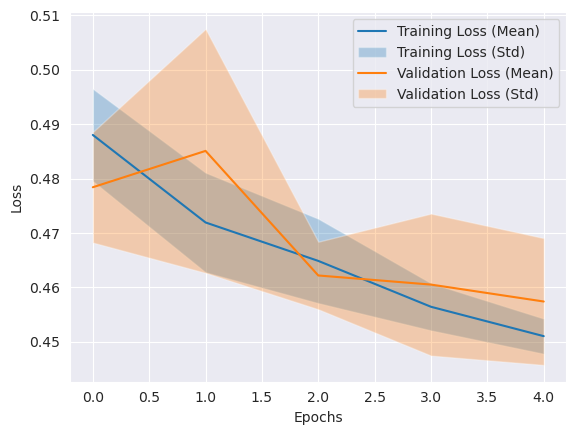

In [19]:
# Affichage des graphiques pour loss
import numpy as np
import matplotlib.pyplot as pl

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

426/426 [==============================] - 1s 3ms/step


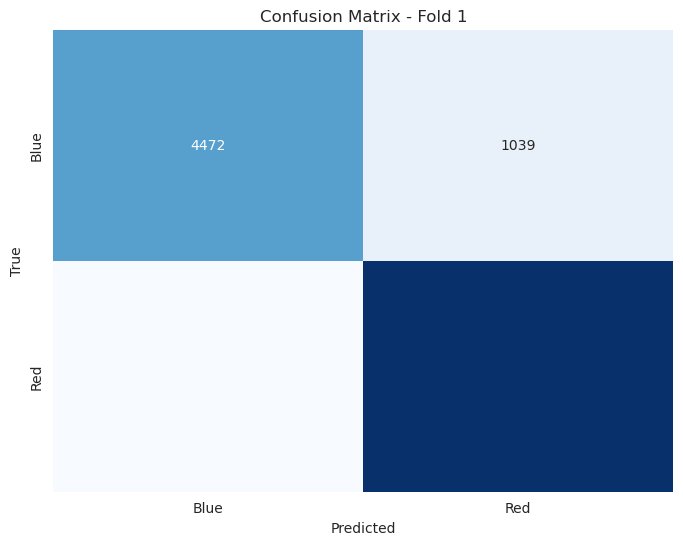

F1 Score - Fold 1: 0.9079732633086656
426/426 [==============================] - 1s 3ms/step


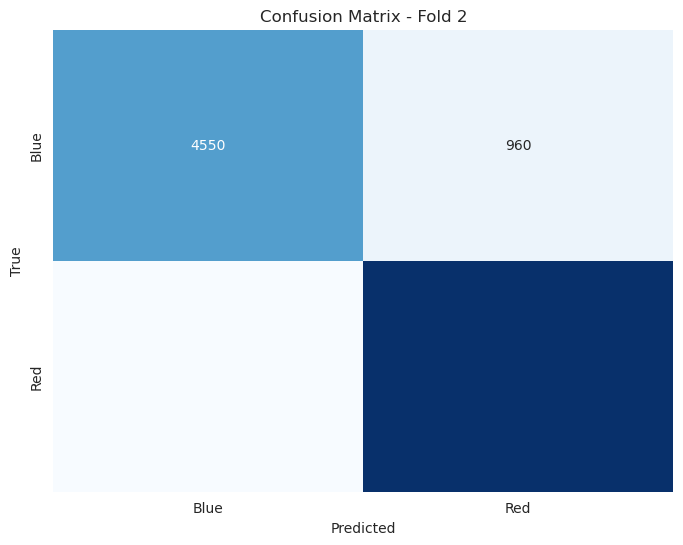

F1 Score - Fold 2: 0.9091455715230593
426/426 [==============================] - 1s 2ms/step


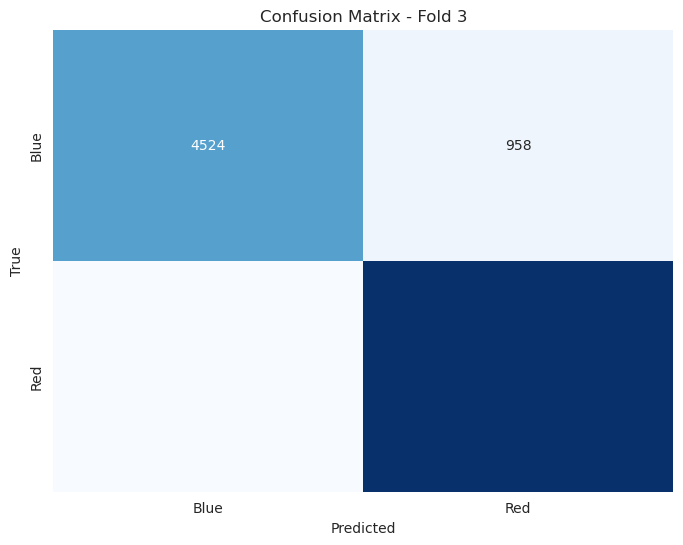

F1 Score - Fold 3: 0.9033813513350611


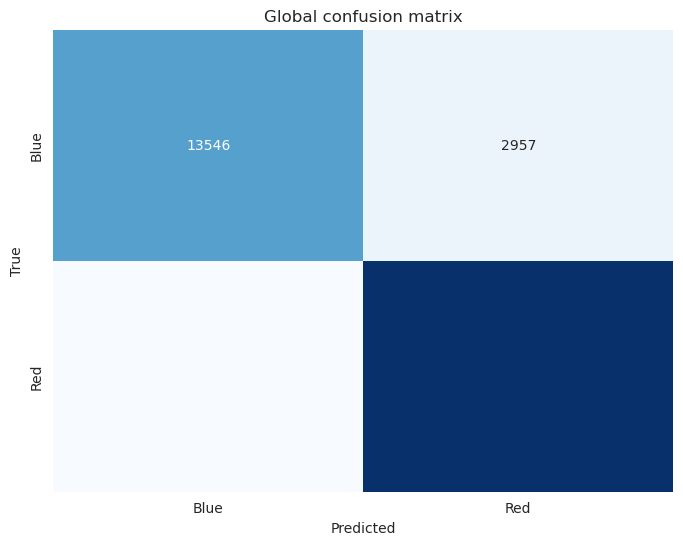

Mean F1 Score across all folds: 0.9068333953889286


In [22]:
# TODO ça marche pas :/
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Blue", "Red"], yticklabels=["Blue", "Red"])
    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))

for i, (train_index, test_index) in enumerate(kf.split(mice25features_input)):
    # Evaluate the trained model on the test fold
    predictions = (trained_mlp[i].predict(mice25features_input[test_index]) > 0).astype(int)
    true_labels = (mice25features_output[test_index] > 0).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    mean_confusion_matrix += confusion_matrix(true_labels, predictions)

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    f1 = f1_score(true_labels, predictions)
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")
